## Using the betting odds in these predictions

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import  RandomizedSearchCV
from scipy.stats import uniform, randint

In [37]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [38]:
seasons_df=pd.read_pickle('data/seasons_betting_df.pkl')

In [39]:
seasons_df['Date'].is_monotonic_increasing

True

Going to one hot encode the 2 team names. So I can see if the relationship status between the two teams is important

In [40]:
seasons_df=pd.get_dummies(seasons_df, columns=['HomeTeam', 'AwayTeam'])
#seasons_df.drop(columns=['HomeTeam','AwayTeam'], inplace=True)

In [41]:
#I was just doing this to see if the betting stats alone would get the same results.
#I discovered that with just using these stats my models performed about 4% worse on accuracy across all models
#seasons_df=seasons_df[['B365H','B365D','B365A','MaxH','AvgH','MaxD','AvgD','MaxA','AvgA','season','FTR']]

In [42]:
#no nulls once all teams have played 4 games
seasons_df[(seasons_df['home.matchNumber']>=4) & (seasons_df['away.matchNumber']>=4)].isna().any().any()

True

In [43]:
pd.set_option('future.no_silent_downcasting', True)
seasons_df=seasons_df.fillna(0)

In [44]:
seasons_df.drop(columns=['Date'], inplace=True)

In [45]:
label_encoder = LabelEncoder()
seasons_df['label'] = label_encoder.fit_transform(seasons_df['FTR'])

Make the train and test sets

In [46]:
#filtering out the matches before a team has played 3 matches that season
#seasons_df=seasons_df.dropna()


In [47]:
train=seasons_df[~(seasons_df['season']=='season23')]
train=train.copy()
train.drop('season', axis=1, inplace=True)

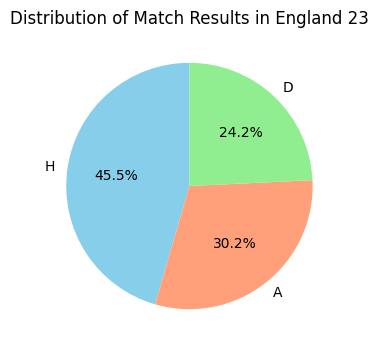

In [48]:
# Calculate value counts for 'result' column
result_counts = train['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England 23")
plt.show()


In [49]:
X_train=train.drop(['label','FTR'], axis=1)
y_train=train['label']

In [50]:
test=seasons_df[seasons_df['season']=='season23']
test=test.copy()
test.drop('season', axis=1, inplace=True)

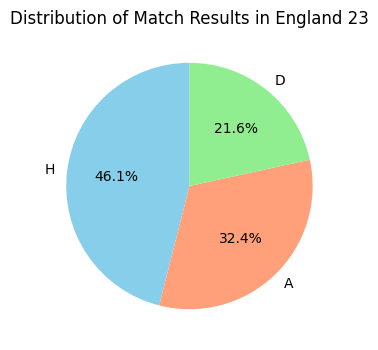

In [51]:
# Calculate value counts for 'result' column
result_counts = test['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England 23")
plt.show()


In [52]:
X_test=test.drop(['label', 'FTR'], axis=1)
y_test=test['label']

Scale the features

In [53]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
X_test

array([[-1.68704696, -1.68706278,  2.46655125, ..., -0.22065615,
        -0.12038585, -0.17149859],
       [-1.68704696, -1.68706278, -0.8134401 , ..., -0.22065615,
        -0.12038585, -0.17149859],
       [-1.68704696, -1.68706278, -0.08241563, ...,  4.53193795,
        -0.12038585, -0.17149859],
       ...,
       [ 1.68649853,  1.6876114 ,  0.0137718 , ..., -0.22065615,
        -0.12038585, -0.17149859],
       [ 1.68649853,  1.6876114 , -0.86153381, ...,  4.53193795,
        -0.12038585, -0.17149859],
       [ 1.68649853,  1.6876114 ,  1.9856141 , ..., -0.22065615,
        -0.12038585, -0.17149859]])

### RandomForest

In [ ]:
# Step 4: Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

In [ ]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

In [ ]:
def evaluate_model(model, X_test, y_test, label_encoder):
    """
    Evaluate the model's performance using accuracy and a classification report.
    
    Parameters:
    model: The trained model
    X_test: Test features
    y_test: Actual labels for the test set
    label_encoder: The label encoder used to transform labels
    
    Returns:
    None
    """
    # Step 1: Make predictions
    y_pred = model.predict(X_test)
    
    # Step 2: Convert predicted numeric labels back to original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    # Step 3: Convert actual labels back to original labels
    y_test_labels = label_encoder.inverse_transform(y_test)
    
    # Step 4: Calculate and print accuracy
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print(f"Model accuracy: {accuracy:.2f}")
    
    # Step 5: Generate and print classification report
    class_report = classification_report(y_test_labels, y_pred_labels)
    print("\nClassification Report:")
    print(class_report)



In [ ]:

evaluate_model(model, X_test, y_test, label_encoder)

In [ ]:
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:

# Get feature importance from the model
feature_importances = model.feature_importances_

# Create a DataFrame to make it easier to read
feature_importance_df = pd.DataFrame({
    'Feature': train.drop(['label','FTR'], axis=1).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

## Plot the feature importance
#plt.figure(figsize=(10, 6))
#plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
#plt.xlabel('Importance')
#plt.title('Feature Importance')
#plt.show()

In [ ]:
%%time
#Wall time: 5min 4s

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_iter=10, verbose=1)
random_search.fit(X_train, y_train)
print(f'Best Parameters: {random_search.best_params_}')

In [ ]:
#Evaluate the model
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


In [ ]:

evaluate_model(random_search, X_test, y_test, label_encoder)

In [ ]:
y_pred_labels = label_encoder.inverse_transform(y_pred)
# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## XGBoost

In [ ]:
# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test)


In [ ]:

evaluate_model(model, X_test, y_test, label_encoder)

In [ ]:
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
%%time
#Wall time: 2min 8s

# Define the model
model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 1000),          # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),         # Learning rate
    'max_depth': randint(3, 10),                 # Max depth of tree
    'min_child_weight': randint(1, 10),          # Min child weight
    'subsample': uniform(0, 1),              # Fraction of samples used for each tree
    'colsample_bytree': uniform(0, 1),       # Fraction of features for each tree
    'gamma': uniform(0, 1),                      # Gamma (min loss reduction)
    'reg_alpha': uniform(0, 1),                  # L1 regularization term
    'reg_lambda': uniform(0, 1),                 # L2 regularization term
}

# Define the recall scorer for multiclass classification
#f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV with the updated scorer
random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                   n_iter=10, cv=5, scoring='accuracy',
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters
print(f'Best Parameters: {random_search.best_params_}')

In [ ]:
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


In [ ]:
evaluate_model(random_search, X_test, y_test, label_encoder)

In [ ]:
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# manually tuning
best_params = {
    'colsample_bytree': 0.60,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 500,
    'gamma': 0.4, # low value means more splits
    'reg_alpha': 0.37, # higher values reduce over fitting
    'reg_lambda': 0.79, # higher values reduce over fittin
    'subsample': 0.20
}

model = xgb.XGBClassifier(**best_params)

model.fit(X_train, y_train)

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [ ]:
evaluate_model(model, X_test, y_test, label_encoder)

In [ ]:
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Get feature importance from the model
feature_importances = model.feature_importances_

# Create a DataFrame to make it easier to read
feature_importance_df = pd.DataFrame({
    'Feature': train.drop(['label','FTR'], axis=1).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
feature_importance_df.head(50)

## Plot the feature importance
#plt.figure(figsize=(10, 6))
#plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
#plt.xlabel('Importance')
#plt.title('Feature Importance')
#plt.show()